[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/face_detection.ipynb)

# Face Detection and blurring

In this tutorials we will show how to use
- The [Face Detection](https://kornia.readthedocs.io/en/latest/applications/face_detection.html) API in CPU/GPU.
- Blur the detected images.

In [ ]:
%%capture
!pip install git+https://github.com/kornia/kornia

Import the needed libraries

In [ ]:
import cv2
import kornia as K
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia.contrib import FaceDetector, FaceDetectorResult

# select the device and type
device = torch.device("cpu")  # use 'cuda:0'
dtype = torch.float32

Read the image and convert to a `torch.Tensor`

In [ ]:
import os


def get_data_directory(base):
    path = os.path.join("../", base)
    if os.path.isdir(os.path.join(path, "data")):
        return os.path.join(path, "data/")
    return get_data_directory(path)

In [ ]:
# load the image and scale (if needed)
img_raw = cv2.imread(get_data_directory("") + "crowd.jpg", cv2.IMREAD_COLOR)

# preprocess
img = K.image_to_tensor(img_raw, keepdim=False).to(device, dtype)
img = K.color.bgr_to_rgb(img)

img_vis = K.tensor_to_image(img.byte().clone())  # to later visualise

(-0.5, 1799.5, 1172.5, -0.5)

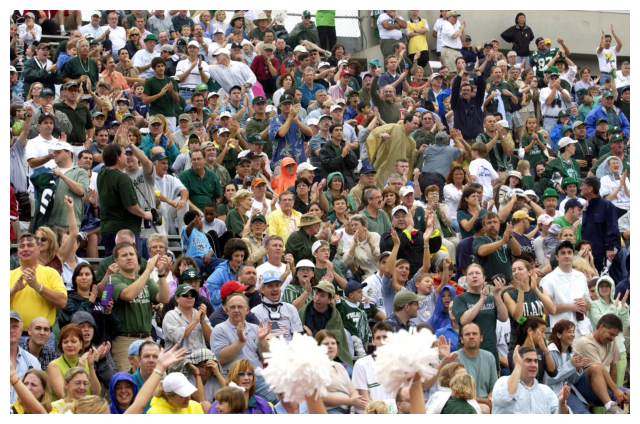

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(K.tensor_to_image(img.byte()))
plt.axis("off")

Create the [FaceDetector](https://kornia.readthedocs.io/en/latest/contrib.html#kornia.contrib.FaceDetector) object and apply to the image

In [ ]:
# create the detector and find the faces !
face_detection = FaceDetector().to(device, dtype)

with torch.no_grad():
    dets = face_detection(img)

# to decode later the detections
dets = [FaceDetectorResult(o) for o in dets]

Create a function to crop the faces from the original image and apply blurring using the [gaussian_blurd2d](https://kornia.readthedocs.io/en/latest/filters.html?highlight=gaussian%20blur#kornia.filters.gaussian_blur2d) operator.

Alternatively, explore other blur operator in [`kornia.filters`](https://kornia.readthedocs.io/en/latest/filters.html).

In [ ]:
# blurring paramters
k: int = 21  # kernel_size
s: float = 35.0  # sigma


def apply_blur_face(img: torch.Tensor, img_vis: np.ndarray, x1, y1, x2, y2):
    # crop the face
    roi = img[..., y1:y2, x1:x2]

    # apply blurring and put back to the visualisation image
    roi = K.filters.gaussian_blur2d(roi, (k, k), (s, s))
    roi = K.color.rgb_to_bgr(roi)
    img_vis[y1:y2, x1:x2] = K.tensor_to_image(roi)

Let draw the detections and save/visualize the image

True

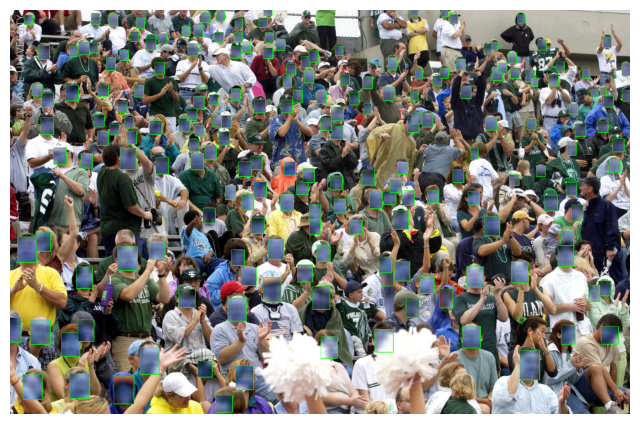

In [ ]:
for b in dets:
    # draw face bounding box around each detected face
    top_left = b.top_left.int().tolist()
    bottom_right = b.bottom_right.int().tolist()
    scores = b.score.tolist()

    for score, tp, br in zip(scores, top_left, bottom_right):
        x1, y1 = tp
        x2, y2 = br

        if score < 0.7:
            continue  # skip detection with low score
        img_vis = cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # blur the detected faces
        apply_blur_face(img, img_vis, x1, y1, x2, y2)

plt.figure(figsize=(8, 8))
plt.imshow(img_vis)
plt.axis("off")

# save and show image
cv2.imwrite("img_out.jpg", img_vis)

## Play with the Real Time Demo

You can achieve 60 FPS in CPU using a standard WebCam.

See: [https://github.com/kornia/kornia/blob/master/examples/face_detection/main_video.py](https://github.com/kornia/kornia/blob/master/examples/face_detection/main_video.py)

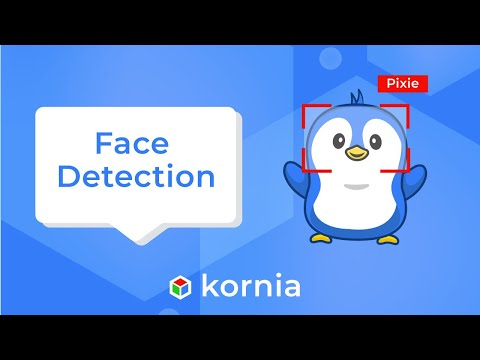

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("hzQroGp5FSQ")